In [4]:
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath("")))

import numpy as np
import matplotlib.pyplot as plt

from basslv import BassLocalVolatility, VanillaCall, BlackPricingEngine, MarketMarginal

Current tol: 0.0001, reach 0.00010303877158712726
Error in zero: 0.02991686658599757
adjusted error in zero: -5.130340596792848e-13

Current tol: 0.0001, reach 0.0005215628836394426
Error in zero: 0.022006464107178936
adjusted error in zero: 6.161737786669619e-15

Current tol: 0.0001, reach 0.0008871216182841923
Error in zero: 0.01842999601873646
adjusted error in zero: -3.1108449149996886e-13



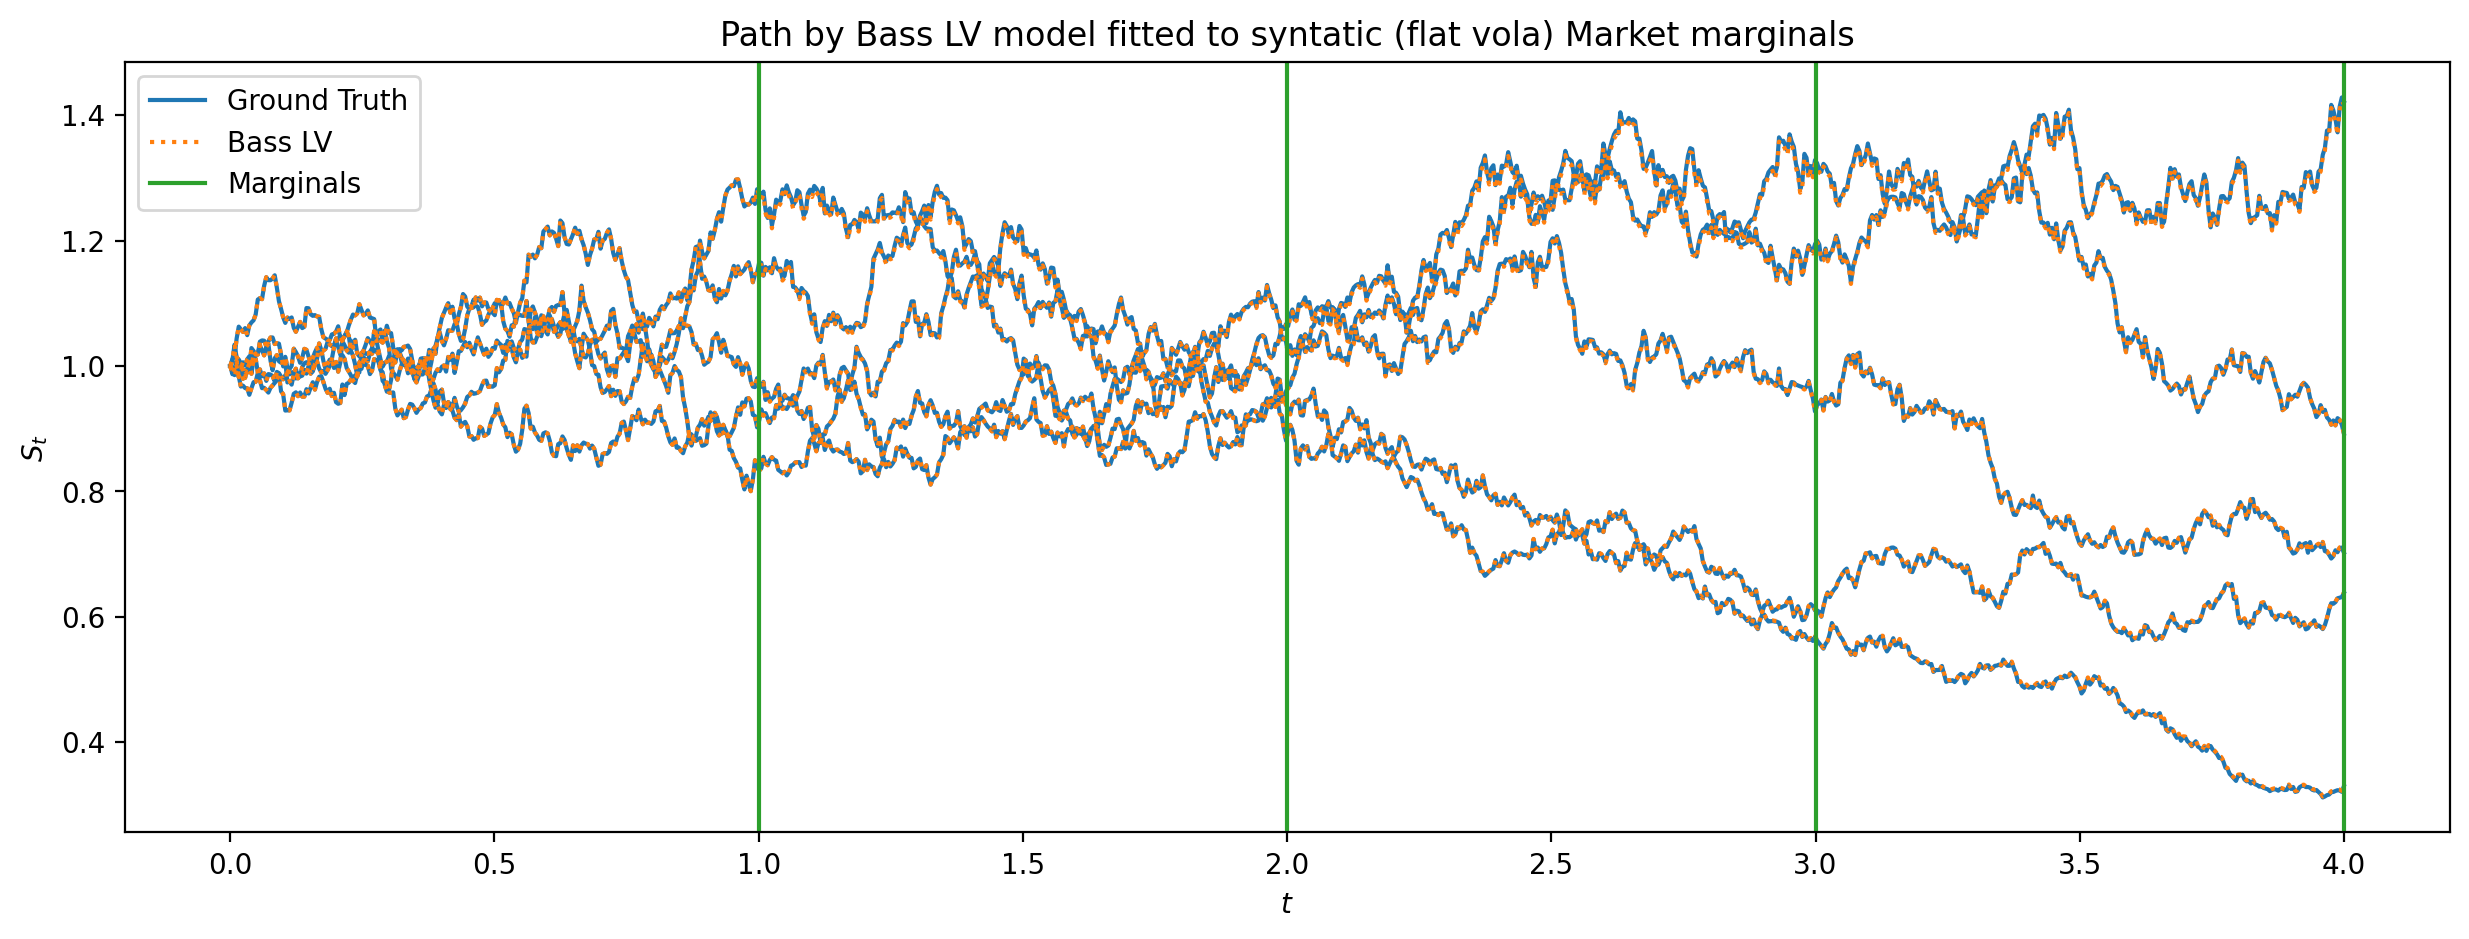

In [6]:
sigma = 0.2
tenors = [1., 2., 3., 4.]
timeGridPoints = 1000
pathsNumber = 5
SEED = 42

forward = 1.
discountFactor = 1
strikes = np.linspace(0.25, 3., 200, endpoint=True)
volatility = 0.2

callPrices = [
    [
        VanillaCall(
            forward=forward,
            discountFactor=discountFactor,
            timeToExpiry=tenor,
            pricingEngine=BlackPricingEngine()
        ).NPV(strike=strike, volatility=volatility)
        for strike in strikes
    ]
    for tenor in tenors
]

marginals = [
    MarketMarginal(
        strikes=strikes,
        callPrices=callPrices[tenorIndex],
        tenor=tenors[tenorIndex]
    )
    for tenorIndex in range(len(tenors))
]

t = np.linspace(0, tenors[-1], timeGridPoints)

pathsBassLv = BassLocalVolatility().sample(
    t=t,
    pathsNumber=pathsNumber,
    marginals=marginals,
    randomGenerator=np.random.default_rng(SEED),
    fixedPointEquationTolerance=1e-4,
    fixedPointEquationMaxIter=10
)

randomGenerator = np.random.default_rng(SEED)
brownianMotion = np.cumsum(
    randomGenerator.normal(
        size=(pathsNumber, timeGridPoints)
    ) * np.sqrt(np.diff(t, prepend=0)),
    axis=1
)
pathsGroundTruth = np.exp(sigma * brownianMotion - sigma ** 2 * t / 2)


_, axis = plt.subplots(figsize=(15, 5), dpi=200)

handleGroundTruth, *_ = axis.plot(t, pathsGroundTruth.T, c="C0")
handleBassLv, *_ = axis.plot(t, pathsBassLv.T, ls=":", c="C1")
for tenor in tenors:
    handleTime = axis.axvline(tenor, c="C2")

axis.set_xlabel("$t$")
axis.set_ylabel("$S_t$")
axis.set_title("Path by Bass LV model fitted to syntatic (flat vola) Market marginals")
axis.legend(
    handles=[handleGroundTruth, handleBassLv, handleTime],
    labels=["Ground Truth", "Bass LV", "Marginals"],
)

plt.show()
